In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage import graph
from skimage.color import rgb2gray

Görüntü başarıyla yüklendi.


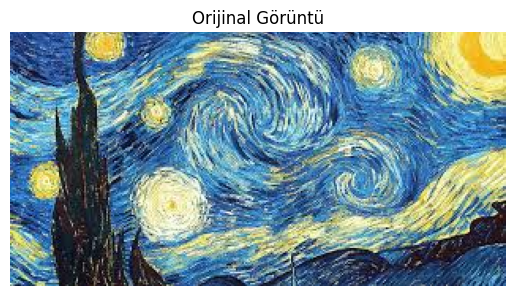

In [11]:
# Örnek bir görüntü yükle. 'peppers.png' gibi renkli ve çeşitli bir görüntü kullanın.
try:
    image_bgr = cv2.imread('image.jpg')
    if image_bgr is None:
        raise FileNotFoundError("Görüntü dosyası 'image.jpg' bulunamadı.")
    
    # OpenCV BGR formatında yükler, biz analiz ve gösterim için RGB formatında kullanacağız.
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    print("Görüntü başarıyla yüklendi.")
    plt.imshow(image_rgb)
    plt.title("Orijinal Görüntü")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Hata: {e}")

Mean-Shift segmentasyonu başlıyor... Bu işlem biraz zaman alabilir.
Mean-Shift segmentasyonu tamamlandı.


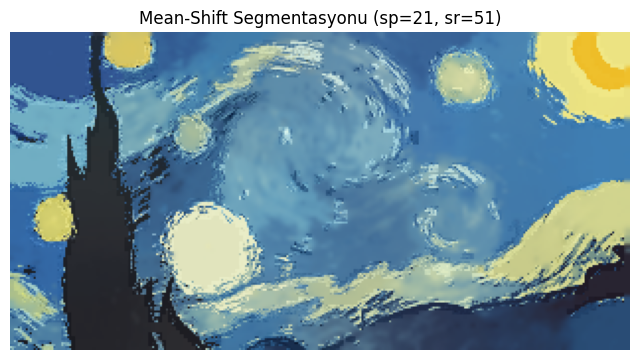

In [12]:
# Mean-Shift Parametreleri
# spatial_radius: Mekansal pencere yarıçapı
# color_radius: Renk uzayındaki pencere yarıçapı
spatial_radius = 21
color_radius = 51

print("Mean-Shift segmentasyonu başlıyor... Bu işlem biraz zaman alabilir.")

# OpenCV'nin optimize edilmiş Mean-Shift fonksiyonunu uygula
segmented_image_meanshift = cv2.pyrMeanShiftFiltering(image_rgb, sp=spatial_radius, sr=color_radius)

print("Mean-Shift segmentasyonu tamamlandı.")

# Sonucu göster
plt.figure(figsize=(8,6))
plt.imshow(segmented_image_meanshift)
plt.title(f'Mean-Shift Segmentasyonu (sp={spatial_radius}, sr={color_radius})')
plt.axis('off')
plt.show()

Normalized Cuts segmentasyonu tamamlandı.


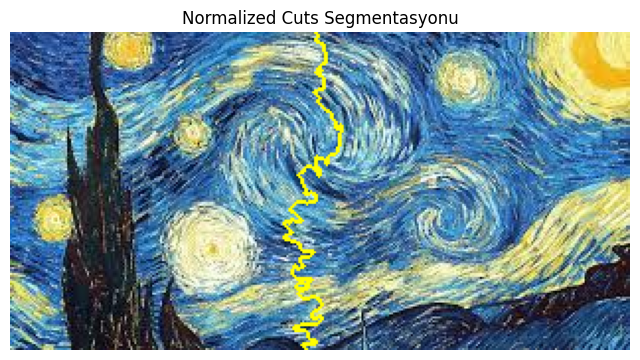

In [13]:
# Normalized Cuts doğrudan pikseller üzerinde çok maliyetli olduğu için,
# önce görüntüyü SLIC ile süper-piksellere ayırıp grafiği bu bölgeler üzerinden kurarız.

# 1. SLIC ile süper-piksel segmentasyonu
slic_labels = slic(image_rgb, n_segments=250, compactness=10, sigma=1, start_label=1)

# 2. Bölge Bitişiklik Grafiği (Region Adjacency Graph - RAG) oluşturma
# Bu grafikte her düğüm bir süper-piksel bölgesidir.
rag = graph.rag_mean_color(image_rgb, slic_labels)

# 3. Normalized Cut uygulama
# `thresh` parametresi ne kadar benzer bölgelerin birleştirileceğini kontrol eder.
# Düşük eşik daha fazla, yüksek eşik daha az segment oluşturur.
ncut_labels = graph.cut_normalized(slic_labels, rag, thresh=0.08)

# 4. Sonucu görselleştirme
ncut_result = mark_boundaries(image_rgb, ncut_labels)

print("Normalized Cuts segmentasyonu tamamlandı.")

plt.figure(figsize=(8,6))
plt.imshow(ncut_result)
plt.title("Normalized Cuts Segmentasyonu")
plt.axis('off')
plt.show()

GrabCut segmentasyonu başlıyor...
GrabCut segmentasyonu tamamlandı.


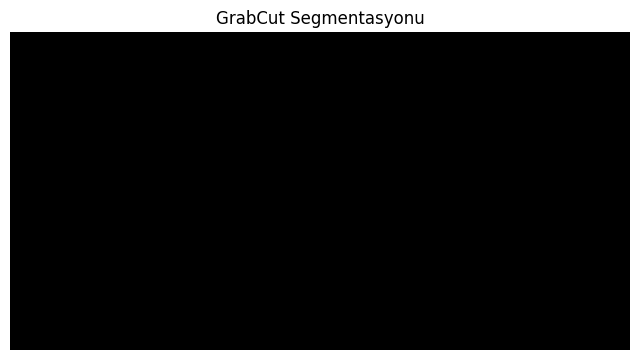

In [14]:
print("GrabCut segmentasyonu başlıyor...")

# GrabCut'ın çalışması için bir maske ve dahili olarak kullanacağı modeller gerekir.
mask = np.zeros(image_rgb.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Kullanıcının çizeceği dikdörtgeni simüle edelim.
# (başlangıç_x, başlangıç_y, genişlik, yükseklik)
rect = (50, 20, image_rgb.shape[1]-100, image_rgb.shape[0]-40)

# GrabCut algoritmasını çalıştır
# 5 iterasyon ile modeli iyileştiriyoruz.
cv2.grabCut(image_rgb, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Maskede 0 ve 2 olan değerler arka plan, 1 ve 3 olanlar ön plandır.
# Sadece ön planı tutmak için bir maske oluşturalım.
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Orijinal görüntüyü bu maske ile çarparak sadece ön planı alalım.
grabcut_result = image_rgb * mask2[:, :, np.newaxis]

print("GrabCut segmentasyonu tamamlandı.")

plt.figure(figsize=(8,6))
plt.imshow(grabcut_result)
plt.title("GrabCut Segmentasyonu")
plt.axis('off')
plt.show()

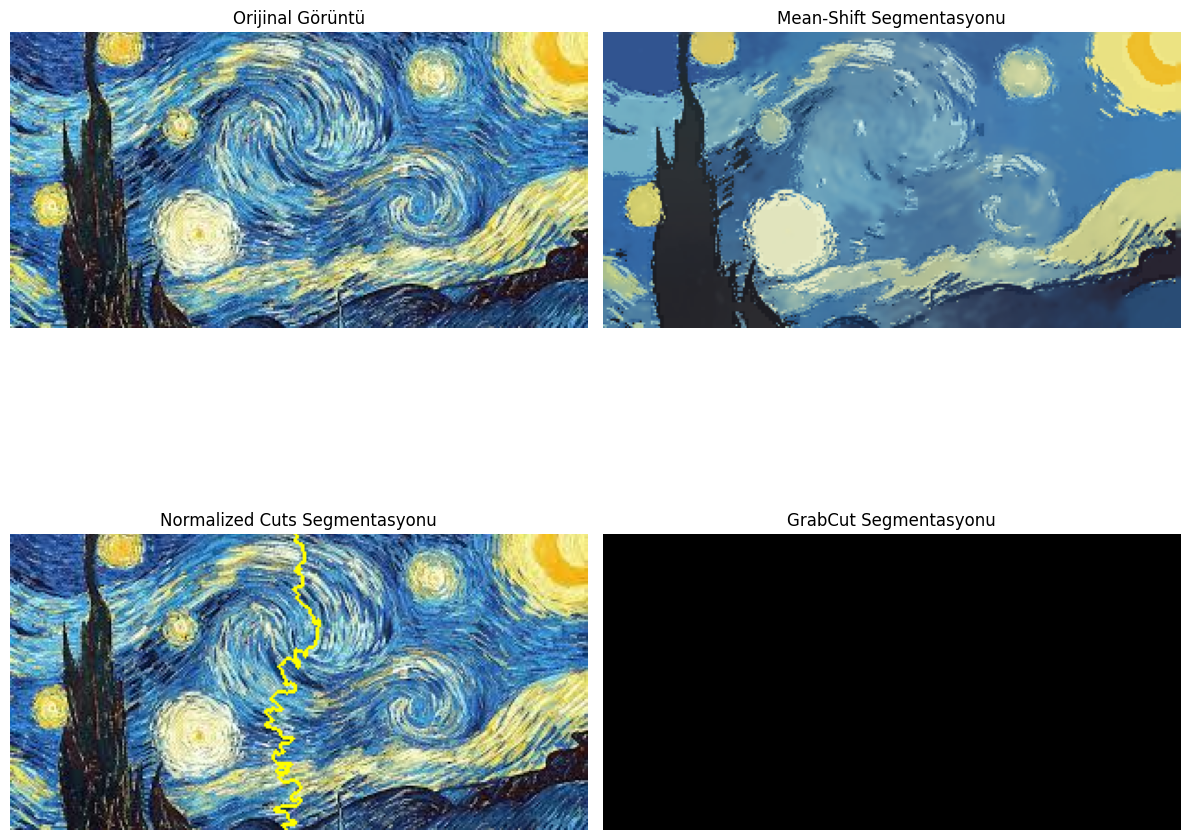

In [15]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Orijinal Görüntü')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(segmented_image_meanshift)
plt.title('Mean-Shift Segmentasyonu')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(ncut_result)
plt.title('Normalized Cuts Segmentasyonu')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(grabcut_result)
plt.title('GrabCut Segmentasyonu')
plt.axis('off')

plt.tight_layout()
plt.show()